In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

In [2]:
# Chargement des données
file_path = 'C:/Users/Hiba/Desktop/S7/Deep learning/trading/nifty50.csv'  # Remplacez par votre chemin de fichier
data = pd.read_csv(file_path)

C:\Users\Hiba\AppData\Local\Temp\ipykernel_10112\204611382.py:3: DtypeWarning: Columns (12) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


In [5]:
# Vérifiez les colonnes et choisissez celle à prédire
print(data.columns)  # Affiche les colonnes pour choisir la bonne
target_column = 'Close'  # Remplacez par la colonne cible

Index(['Date', 'Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last',
       'Close', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume',
       '%Deliverble'],
      dtype='object')


In [7]:
# Prétraitement des données
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data[target_column].values.reshape(-1, 1))

In [9]:
# Création des séquences pour LSTM
def create_sequences(data, seq_length):
    x, y = [], []
    for i in range(len(data) - seq_length):
        x.append(data[i:i + seq_length])
        y.append(data[i + seq_length])
    return np.array(x), np.array(y)

In [11]:
sequence_length = 60  # Par exemple, 60 jours
x, y = create_sequences(scaled_data, sequence_length)

In [13]:
# Diviser les données en ensembles d'entraînement et de test
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [17]:
# Construction du modèle LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(x_train.shape[1], 1)),
    LSTM(50, return_sequences=False),
    Dense(25, activation='relu'),
    Dense(1)  # Une seule sortie pour la prédiction
])

C:\Users\Hiba\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [19]:
# Compilation du modèle
model.compile(optimizer='adam', loss='mean_squared_error')

In [21]:
# Entraînement du modèle
history = model.fit(x_train, y_train, batch_size=32, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 172s 29ms/step - loss: 2.1114e-04 - val_loss: 1.9161e-05
Epoch 2/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 158s 27ms/step - loss: 3.7677e-05 - val_loss: 1.4930e-05
Epoch 3/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 164s 28ms/step - loss: 1.3229e-05 - val_loss: 1.5591e-05
Epoch 4/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 163s 28ms/step - loss: 3.0955e-05 - val_loss: 1.1010e-05
Epoch 5/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 160s 28ms/step - loss: 1.7152e-05 - val_loss: 1.0518e-05
Epoch 6/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 159s 27ms/step - loss: 1.7645e-05 - val_loss: 1.4469e-05
Epoch 7/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 165s 28ms/step - loss: 1.8862e-05 - val_loss: 1.0665e-05
Epoch 8/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 165s 28ms/step - loss: 1.2008e-05 - val_loss: 1.0739e-05
Epoch 9/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 164s 28ms/step - loss: 2.2121e-05 - val_loss: 1.0425e-05
Epoch 10/10
5803/5803 ━━━━━━━━━━━━━━━━━━━━ 166s 29ms/step - loss: 1.6828e-05 - val_loss: 1.0548e-05


In [22]:
# Évaluation du modèle
loss = model.evaluate(x_test, y_test)
print(f"Perte du modèle : {loss}")

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 15s 11ms/step - loss: 4.0378e-06
Perte du modèle : 1.0547931196924765e-05


In [23]:
# Prédictions
predictions = model.predict(x_test)
predictions = scaler.inverse_transform(predictions)  # Revenir à l'échelle originale

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 15s 10ms/step


In [24]:
# Revenir les valeurs réelles à l'échelle originale
y_test_scaled = scaler.inverse_transform(y_test.reshape(-1, 1))

In [25]:
# Calcul de l'accuracy (Mean Absolute Percentage Error)
def calculate_mape(y_true, y_pred):
    """Calcule le Mean Absolute Percentage Error (MAPE)."""
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [26]:
mape = calculate_mape(y_test_scaled, predictions)
accuracy = 100 - mape  # Pourcentage d'accuracy
print(f"MAPE : {mape:.2f}%")
print(f"Accuracy : {accuracy:.2f}%")

MAPE : 3.55%
Accuracy : 96.45%


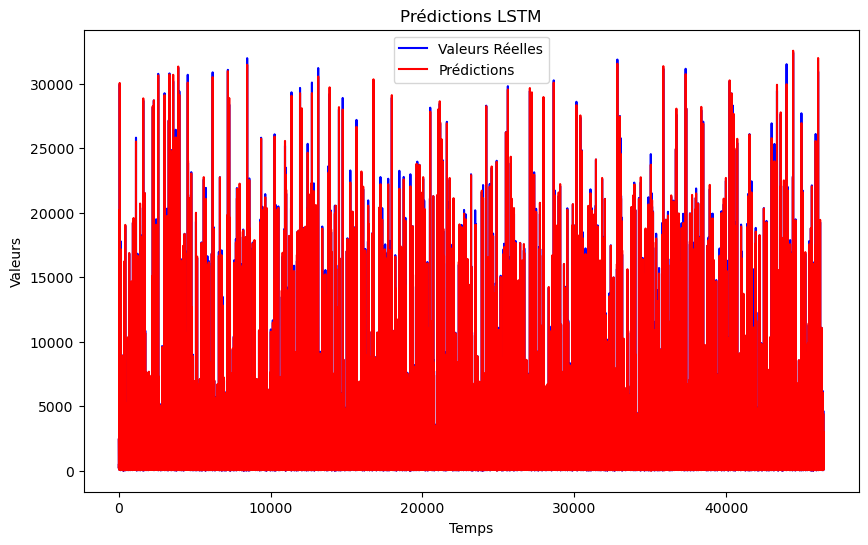

In [33]:
# Visualisation des résultats
plt.figure(figsize=(10, 6))
plt.plot(y_test_scaled, color='blue', label='Valeurs Réelles')
plt.plot(predictions, color='red', label='Prédictions')
plt.title("Prédictions LSTM")
plt.xlabel("Temps")
plt.ylabel("Valeurs")
plt.legend()
plt.show()